In [1]:
import pyspark

In [20]:
from pyspark.sql.functions import col, when, count, isnan, hour, dayofweek, avg, desc


In [2]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("eda") \
    .config("spark.executor.memory", "1g") \
    .getOrCreate()

In [5]:
df = spark.read.format("parquet").option("header", True).load("hdfs://namenode:9000/proj/merged_data.parquet")

In [12]:
rows = df.limit(5).collect()  # You can increase to 10, 20 safely

for i, row in enumerate(rows, 1):
    print(f"\n--- Row {i} ---")
    for k, v in row.asDict().items():
        print(f"{k:<25} {v}")



--- Row 1 ---
vendorid                  1
tpep_pickup_datetime      2022-01-01 00:35:40
tpep_dropoff_datetime     2022-01-01 00:53:29
passenger_count           2
trip_distance             3.8
ratecodeid                1
store_and_fwd_flag        N
pulocationid              142
dolocationid              236
payment_type              1
fare_amount               14.5
extra                     3.0
mta_tax                   0.5
tip_amount                3.65
tolls_amount              0.0
improvement_surcharge     0.3
total_amount              21.95
congestion_surcharge      2.5
airport_fee               0.0

--- Row 2 ---
vendorid                  1
tpep_pickup_datetime      2022-01-01 00:33:43
tpep_dropoff_datetime     2022-01-01 00:42:07
passenger_count           1
trip_distance             2.1
ratecodeid                1
store_and_fwd_flag        N
pulocationid              236
dolocationid              42
payment_type              1
fare_amount               8.0
extra                  

In [50]:
from pyspark.sql.functions import col, sum as spark_sum

# Create a list of (column, null_count) pairs
null_counts = df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])

# Convert to long format for readable output
null_counts_long = null_counts.selectExpr(
    f"stack({len(df.columns)}, " +
    ", ".join([f"'{c}', {c}" for c in df.columns]) +
    ") as (column, null_count)"
)

# Show neatly
null_counts_long.orderBy("null_count", ascending=False).show(truncate=False)



+---------------------+----------+
|column               |null_count|
+---------------------+----------+
|passenger_count      |2677659   |
|ratecodeid           |2677659   |
|store_and_fwd_flag   |2677659   |
|congestion_surcharge |2677659   |
|airport_fee          |2677659   |
|vendorid             |0         |
|tpep_pickup_datetime |0         |
|tpep_dropoff_datetime|0         |
|trip_distance        |0         |
|pulocationid         |0         |
|dolocationid         |0         |
|payment_type         |0         |
|fare_amount          |0         |
|extra                |0         |
|mta_tax              |0         |
|tip_amount           |0         |
|tolls_amount         |0         |
|improvement_surcharge|0         |
|total_amount         |0         |
|pickup_hour          |0         |
+---------------------+----------+
only showing top 20 rows



In [16]:
df.describe(["trip_distance", "fare_amount", "tip_amount","tolls_amount"]).show()


+-------+------------------+------------------+-----------------+------------------+
|summary|     trip_distance|       fare_amount|       tip_amount|      tolls_amount|
+-------+------------------+------------------+-----------------+------------------+
|  count|          77966324|          77966324|         77966324|          77966324|
|   mean| 5.040316677493284|14.863480149198923| 5.41063103760678|0.5625480585657543|
| stddev|459.57926615918797|15924.270135537783|15924.02772796709| 2.122446607724235|
|    min|               0.0|     -1.33391414E8|           -411.0|            -99.99|
|    max|         389678.46|         401092.32|   1.3339136353E8|            911.87|
+-------+------------------+------------------+-----------------+------------------+



In [24]:
from pyspark.sql.functions import hour, dayofweek



In [25]:
df = df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

hourly_counts = df.groupBy("pickup_hour").count().orderBy("pickup_hour")
hourly_counts.show(24)

+-----------+-------+
|pickup_hour|  count|
+-----------+-------+
|          0|2191644|
|          1|1457380|
|          2| 967400|
|          3| 639442|
|          4| 437860|
|          5| 478799|
|          6|1148268|
|          7|2184822|
|          8|2963847|
|          9|3340985|
|         10|3661240|
|         11|3975487|
|         12|4304044|
|         13|4417794|
|         14|4727971|
|         15|4849770|
|         16|4833760|
|         17|5250467|
|         18|5502836|
|         19|4950538|
|         20|4342471|
|         21|4254985|
|         22|3932541|
|         23|3151973|
+-----------+-------+



In [26]:
pdf = hourly_counts.toPandas()


/tmp/ipykernel_1056/1775436749.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x="pickup_hour", y="count", palette="viridis")


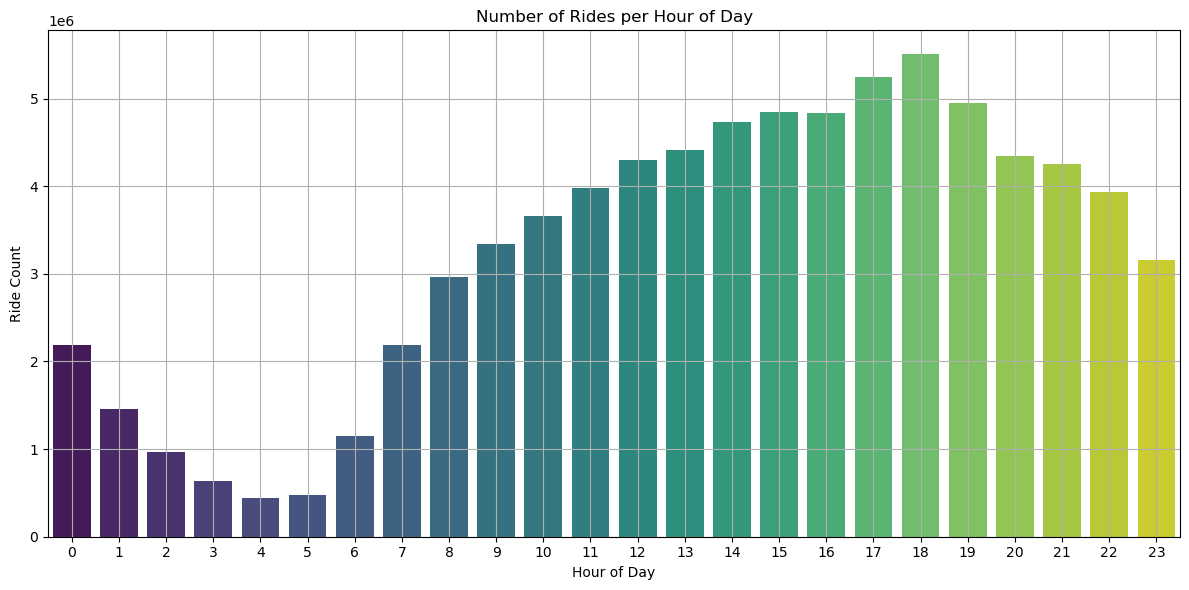

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=pdf, x="pickup_hour", y="count", palette="viridis")
plt.title("Number of Rides per Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Ride Count")
plt.grid(True)
plt.xticks(range(24))
plt.tight_layout()
plt.show()


In [28]:
top_2 = pdf.sort_values(by="count", ascending=False).head(2)
bottom_2 = pdf.sort_values(by="count", ascending=True).head(2)

# Display them
print(" Top 2 Busiest Hours:")
for _, row in top_2.iterrows():
    print(f"Hour {row['pickup_hour']} with {row['count']:,} rides")

print("\n Bottom 2 Least Busy Hours:")
for _, row in bottom_2.iterrows():
    print(f"Hour {row['pickup_hour']} with {row['count']:,} rides")


🚀 Top 2 Busiest Hours:
Hour 18 with 5,502,836 rides
Hour 17 with 5,250,467 rides

😴 Bottom 2 Least Busy Hours:
Hour 4 with 437,860 rides
Hour 5 with 478,799 rides


In [29]:
from pyspark.sql.functions import dayofweek, hour

# Add both hour and weekday columns (Spark: Sunday=1, Saturday=7)
df = df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
       .withColumn("pickup_dayofweek", dayofweek(col("tpep_pickup_datetime")))

# Group by both hour and weekday
heatmap_df = df.groupBy("pickup_dayofweek", "pickup_hour").count()

# Convert to Pandas for heatmap visualization
heatmap_pdf = heatmap_df.toPandas()

# Pivot to shape for heatmap: Rows = days, Columns = hours
heatmap_pivot = heatmap_pdf.pivot(index="pickup_dayofweek", columns="pickup_hour", values="count")

# Replace Spark's numeric day with human-readable labels
import calendar
day_labels = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
heatmap_pivot.index = [day_labels[d - 1] for d in heatmap_pivot.index]

# Sort days properly
heatmap_pivot = heatmap_pivot.reindex(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])


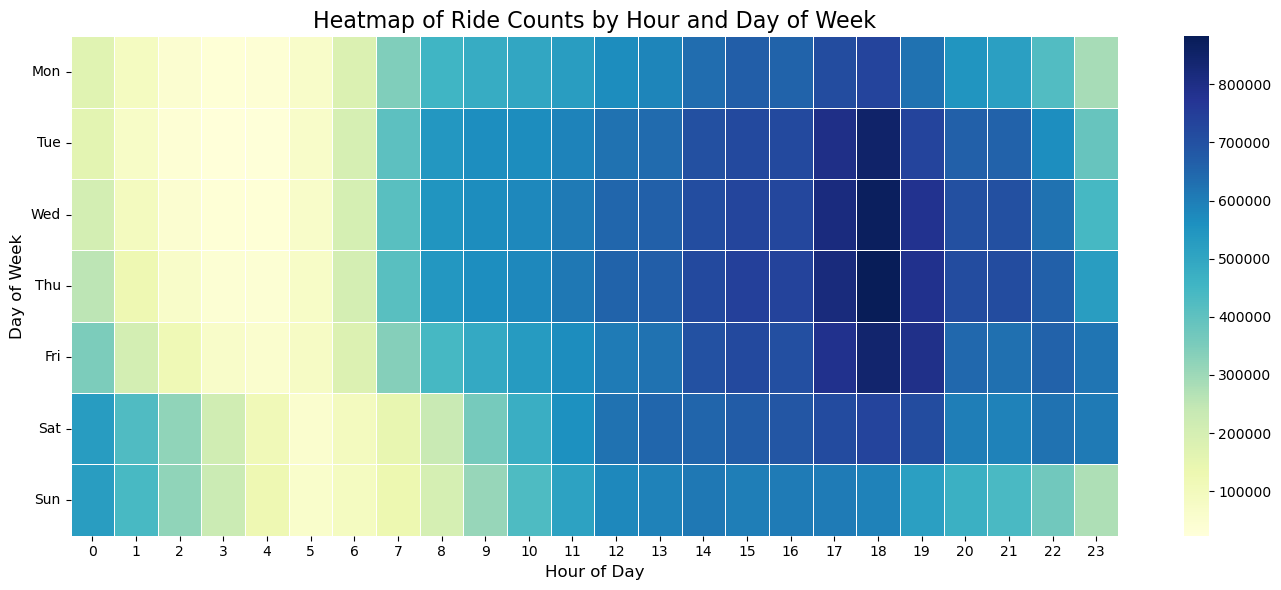

In [30]:
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_pivot, cmap="YlGnBu", linewidths=0.5, annot=False)
plt.title("Heatmap of Ride Counts by Hour and Day of Week", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [31]:
from pyspark.sql.functions import col

# Group by pickup location
pickup_counts = df.groupBy("pulocationid").count().withColumnRenamed("count", "pickup_count")

# Group by dropoff location
dropoff_counts = df.groupBy("dolocationid").count().withColumnRenamed("count", "dropoff_count")

# Rename for clarity before joining
pickup_counts = pickup_counts.withColumnRenamed("pulocationid", "location_id")
dropoff_counts = dropoff_counts.withColumnRenamed("dolocationid", "location_id")

# Join both
location_counts = pickup_counts.join(dropoff_counts, on="location_id", how="outer").fillna(0)

# Optional: convert to integer
location_counts = location_counts.withColumn("pickup_count", col("pickup_count").cast("int"))
location_counts = location_counts.withColumn("dropoff_count", col("dropoff_count").cast("int"))


In [32]:
location_pdf = location_counts.toPandas()
location_pdf["total_activity"] = location_pdf["pickup_count"] + location_pdf["dropoff_count"]

# Sort by total activity
sorted_locations = location_pdf.sort_values(by="total_activity", ascending=False).reset_index(drop=True)


/tmp/ipykernel_1056/3567026787.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_locations.head(top_n), x="location_id", y="total_activity", palette="magma")


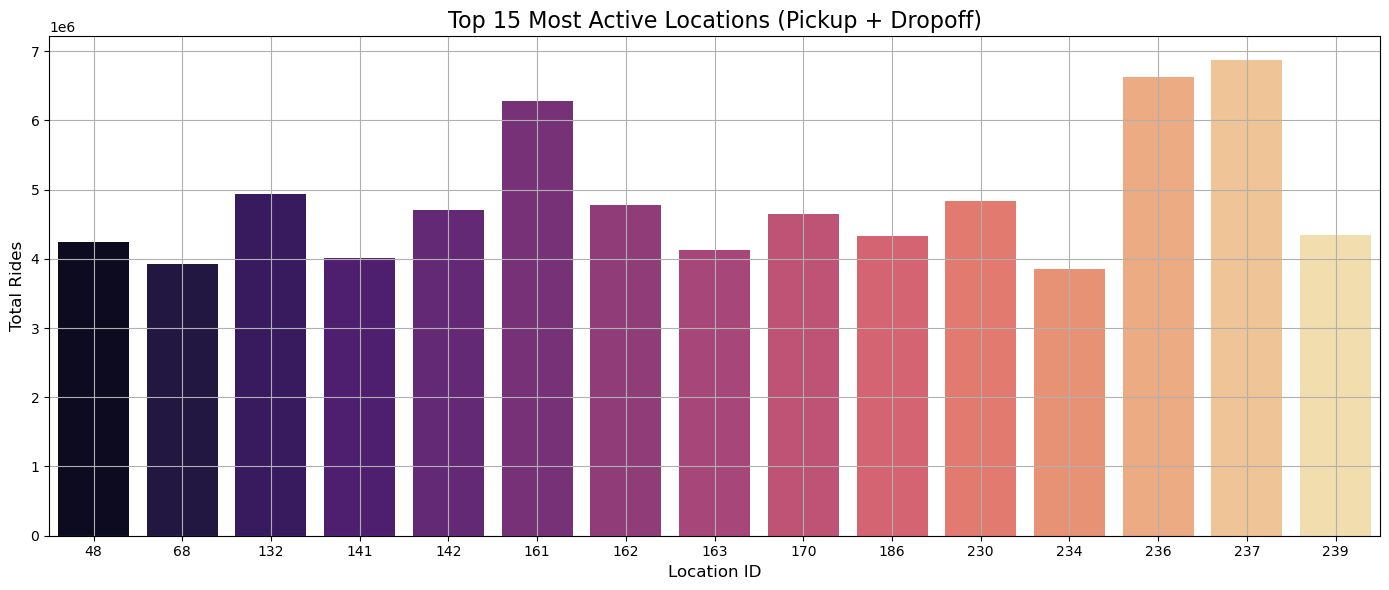

In [33]:
top_n = 15  # Number of locations to plot
plt.figure(figsize=(14, 6))
sns.barplot(data=sorted_locations.head(top_n), x="location_id", y="total_activity", palette="magma")
plt.title(f"Top {top_n} Most Active Locations (Pickup + Dropoff)", fontsize=16)
plt.xlabel("Location ID", fontsize=12)
plt.ylabel("Total Rides", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Top pickup and dropoff locations
top_pickup = location_pdf.sort_values("pickup_count", ascending=False).iloc[0]
top_dropoff = location_pdf.sort_values("dropoff_count", ascending=False).iloc[0]

print("📌 Insights:")
print(f"🏁 Most Pickups: Location ID {top_pickup['location_id']} with {top_pickup['pickup_count']:,} pickups.")
print(f"🎯 Most Dropoffs: Location ID {top_dropoff['location_id']} with {top_dropoff['dropoff_count']:,} dropoffs.")

# Identify location with highest imbalance
imbalance_df = location_pdf.copy()
imbalance_df["imbalance"] = abs(imbalance_df["pickup_count"] - imbalance_df["dropoff_count"])
top_imbalance = imbalance_df.sort_values("imbalance", ascending=False).head(1).iloc[0]

print(f"⚖️ Most Unbalanced Location: ID {top_imbalance['location_id']} "
      f"has a pickup/dropoff difference of {top_imbalance['imbalance']:,} rides.")



![taxi_zone](taxi_zone_map_brooklyn.jpg)


In [39]:
from pyspark.sql.functions import col

# Filter out any nulls or invalid entries
corr_df = df.select("trip_distance", "tip_amount") \
            .filter((col("trip_distance").isNotNull()) & 
                    (col("tip_amount").isNotNull()))


In [40]:
# Compute Pearson correlation
corr_value = corr_df.stat.corr("trip_distance", "tip_amount", method="pearson")
print(f"Correlation between trip_distance and tip_amount: {corr_value:.4f}")


Correlation between trip_distance and tip_amount: -0.0000


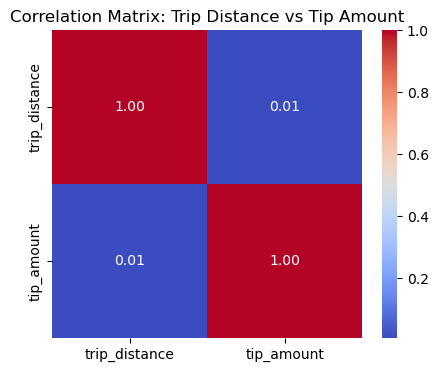

In [41]:
# Sample data to avoid memory overload
sample_pd = corr_df.sample(False, 0.01, seed=42).toPandas()

# Compute full correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = sample_pd.corr(numeric_only=True)

# Plot the correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Trip Distance vs Tip Amount")
plt.show()


In [55]:
from pyspark.sql.functions import col

# Step 1: Filter valid data
corr_df = df.select("trip_distance", "tip_amount") \
            .filter((col("trip_distance").isNotNull()) & 
                    (col("tip_amount").isNotNull()))

# Step 2: Compute Pearson correlation
correlation = corr_df.stat.corr("trip_distance", "tip_amount", method="pearson")

# Step 3: Dynamic Insight
print(f" Correlation between trip_distance and tip_amount: {correlation:.4f}")

# Step 4: Write interpretation dynamically
if correlation > 0.5:
    print(" Insight: There's a strong positive correlation — longer trips tend to receive higher tips.")
elif 0.2 < correlation <= 0.5:
    print(" Insight: There's a moderate positive correlation — tip amounts tend to increase with trip distance.")
elif 0.05 < correlation <= 0.2:
    print(" Insight: A weak positive correlation — tip and distance are slightly related.")
elif -0.05 <= correlation <= 0.05:
    print(" Insight: No significant linear relationship between tip and trip distance.")
else:
    print(" Insight: Negative correlation — longer trips might be receiving smaller tips, which may warrant further analysis.")


 Correlation between trip_distance and tip_amount: -0.0000
 Insight: No significant linear relationship between tip and trip distance.
